In [2]:
import numpy as np
import random
import os
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
from sklearn.datasets import fetch_openml
from sklearn.model_selection import KFold

In [4]:
# ---- Data ----

if not os.path.exists("train_data"):
    os.mkdir("train_data")
    mnist = fetch_openml("mnist_784", version=1)
    X, y = mnist["data"].values.astype(float).reshape(-1, 28, 28) / 255., mnist["target"].values.astype(int)
    np.savez_compressed("data/mnist.npz", X=X, y=y)

X, Y = np.load("train_data/mnist.npz").values()

X.shape, Y.shape

((70000, 28, 28), (70000,))

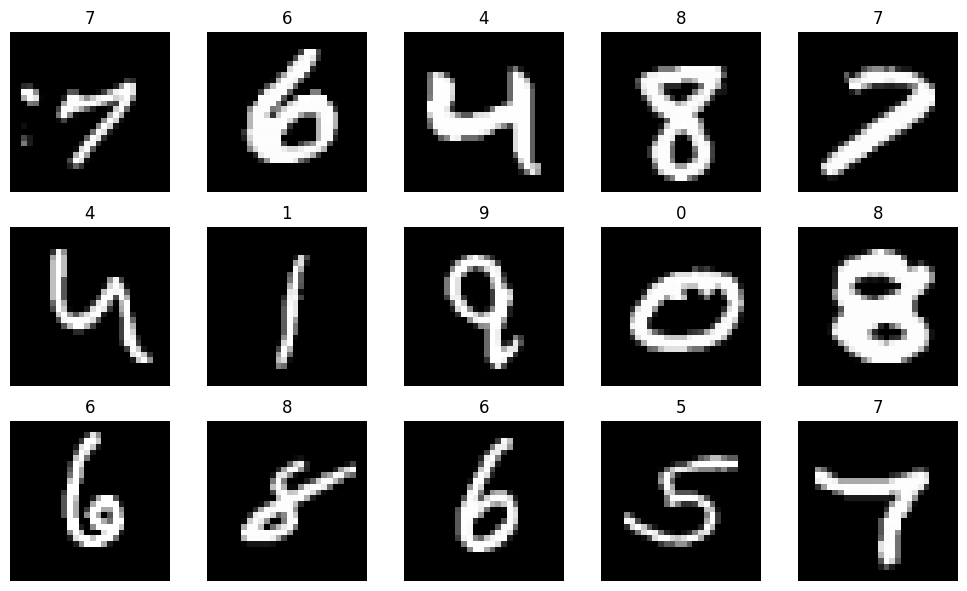

In [5]:
r, c = 3, 5
fig = plt.figure(figsize=(2*c, 2*r))
for _r in range(r):
    for _c in range(c):
        plt.subplot(r, c, _r*c + _c + 1)
        ix = random.randint(0, len(X)-1)
        plt.imshow(X[ix], cmap="gray")
        plt.axis("off")
        plt.title(Y[ix])
plt.tight_layout()
plt.show()

In [7]:
class MLP(torch.nn.Module):

    # Constructor
    def __init__(self, D_i=784, H=100, D_out=10):

        # Super constructor
        super(MLP, self).__init__()

        # Layers
        self.fc1 = torch.nn.Linear(D_i, H)
        self.relu = torch.nn.ReLU()
        self.fc2 = torch.nn.Linear(H, D_out)

    # Forward pass
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

#model_compiled = torch.compile(model)  # optional (new in Pytorch 2.0)
    
model = MLP(784, 100, 10)
outputs = model(torch.randn(64, 784))
outputs.shape

torch.Size([64, 10])

In [6]:
# ---- Dataset ----

class Dataset(torch.utils.data.Dataset):

    # Constructor
    def __init__(self, X, Y):
        self.X = torch.tensor(X).float()
        self.Y = torch.tensor(Y).long()

    # Number of samples in the dataset
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, ix):
        return self.X[ix], self.Y[ix]
    
    # optional func to genereate every batch
    def collate_fn(self, batch):
        x, y = [], []
        for _x, _y in batch:
            x.append(_x)
            y.append(_y)
        return torch.stack(x).view(len(batch), -1), torch.stack(y)  # images are flattened in a single vector    

In [8]:
# ---- Taining ----

dataset = Dataset(X, Y)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=100, collate_fn=dataset.collate_fn)

model = MLP(784, 100, 10)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

epochs = 5
for e in range(1, epochs+1):
    print(f"Epoch {e}/{epochs}")
    for batch_ix, (x, y) in enumerate(dataloader):
        optimizer.zero_grad()           # reset gradients
        outputs = model(x)              # forward pass
        loss = criterion(outputs, y)    # compute loss
        loss.backward()                 # backward pass
        optimizer.step()                # update weights
        if batch_ix % 100 == 0:
            loss, current = loss.item(), (batch_ix + 1) * len(x)
            print(f"loss: {loss:.4f} [{current:>5d}/{len(dataset):>5d}]")

Epoch 1/5
loss: 2.3102 [  100/70000]
loss: 0.4700 [10100/70000]
loss: 0.4873 [20100/70000]
loss: 0.3398 [30100/70000]
loss: 0.2537 [40100/70000]
loss: 0.2783 [50100/70000]
loss: 0.1588 [60100/70000]
Epoch 2/5
loss: 0.1743 [  100/70000]
loss: 0.2198 [10100/70000]
loss: 0.2446 [20100/70000]
loss: 0.1904 [30100/70000]
loss: 0.1497 [40100/70000]
loss: 0.1437 [50100/70000]
loss: 0.0949 [60100/70000]
Epoch 3/5
loss: 0.1174 [  100/70000]
loss: 0.1609 [10100/70000]
loss: 0.1659 [20100/70000]
loss: 0.1574 [30100/70000]
loss: 0.1045 [40100/70000]
loss: 0.0905 [50100/70000]
loss: 0.0644 [60100/70000]
Epoch 4/5
loss: 0.0976 [  100/70000]
loss: 0.1203 [10100/70000]
loss: 0.1238 [20100/70000]
loss: 0.1352 [30100/70000]
loss: 0.0913 [40100/70000]
loss: 0.0637 [50100/70000]
loss: 0.0362 [60100/70000]
Epoch 5/5
loss: 0.0847 [  100/70000]
loss: 0.0899 [10100/70000]
loss: 0.0986 [20100/70000]
loss: 0.1204 [30100/70000]
loss: 0.0757 [40100/70000]
loss: 0.0493 [50100/70000]
loss: 0.0210 [60100/70000]


In [9]:
# ---- Exporting model ----

torch.save(model, "model.pth")

In [10]:
loaded = torch.load("model.pth")
loaded

MLP(
  (fc1): Linear(in_features=784, out_features=100, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=100, out_features=10, bias=True)
)

In [ ]:
batch_size = 100
num_folds = 5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


def validate(model, val_loader, criterion):
    model.eval()
    total_loss = 0.0
    correct = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            correct += predicted.eq(labels).sum().item()
    accuracy = correct / len(val_loader.dataset)
    return total_loss / len(val_loader.dataset), accuracy

# Implement k-fold cross-validation
kf = KFold(n_splits=num_folds)
for fold, (train_indices, val_indices) in enumerate(kf.split(mnist_data)):
    print(f"Fold {fold+1}")
    train_dataset = torch.utils.data.Subset(mnist_data, train_indices)
    val_dataset = torch.utils.data.Subset(mnist_data, val_indices)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    model = MLP().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    num_epochs = 10
    for epoch in range(num_epochs):
        train_loss = train(model, train_loader, criterion, optimizer)
        val_loss, val_accuracy = validate(model, val_loader, criterion)

        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"Train Loss: {train_loss:.4f}")
        print(f"Validation Loss: {val_loss:.4f}")
        print(f"Validation Accuracy: {val_accuracy*100:.2f}%")
    print("-"*30)